# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Schedule:
- Checkpoint Submission (DUE 03 October 2025 @ 11:59PM EST)
- Kaggle Submission (DUE 10 October 2025 @ 11:59PM EST | Slack Deadline is 17 October 2025 @ 11:59PM EST)
- Code Submission (DUE 12 October 2025 @ 11:59PM EST OR Day-of Slack submission)


## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [1]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

## Welcome to the World of Convolutions!
In the previous homework, you learned about Multi-Layer Perceptrons (MLPs), the foundation of deep learning. MLPs demonstrated how networks could learn to predict phonemes from speech data, understand patterns, and even approximate complex functions. However, as powerful as MLPs are, they can struggle when dealing with image data. Flattening images into 1D vectors loses spatial information, like how pixels relate to one another. That’s where Convolutional Neural Networks (CNNs) step in, preserving these relationships and taking us one step closer to designing models that "see" the world as we do.

In this homework, you’ll explore CNNs by working on face classification and verification tasks. Imagine training a model to identify a face from a set of known identities (classification) and then using the same model to decide whether two face images belong to the same person (verification).

For example, given a photo of your friend and a group photo, the classifier would identify your friend’s name, while the verifier would confirm whether two photos depict the same person, even if the person wasn’t part of the training data. CNNs make this possible by extracting hierarchical features from images—from edges and corners in early layers to complex patterns like facial features in deeper layers.

To succeed, you’ll need to understand the nuances of loss functions. Classification relies on Cross-Entropy Loss, which optimizes the model to predict the correct label. For verification, however, we care about embedding similarity. This is where Triplet Loss or** ArcFace Loss** comes in, pushing embeddings of the same person closer together while separating those of different individuals. For instance, a good verification system would ensure that photos of two siblings (often visually similar) are distinguishable in the embedding space, all while being robust to lighting or pose differences.

This homework will also emphasize the practical skills needed for real-world deep learning. You’ll preprocess images, apply data augmentation like flipping or cropping to make the model robust to shifts in the images, and experiment with CNN architectures such as ResNet or ConvNeXt. Along the way, you’ll see how designing a model for classification doesn’t automatically make it suitable for verification, teaching you the importance of aligning task objectives with the right loss function. By the end, you’ll have built a robust system that mimics cutting-edge face recognition applications, from unlocking smartphones to verifying IDs. Let’s take this exciting leap together!

# **SET-UP**


Join the kaggle competition first (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)

## **Colab Users**

#### Step 1: Environment Setup

In [2]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct  3 04:45:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content
!pwd

In [4]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
!pip install torchinfo --quiet # Install torchinfo

#### Step 2: Get Data

In [9]:
# TODO: Use the same Kaggle code from HW2P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
# !mkdir kaggle

with open("kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"siddarthashok","key":"f020f4f825cdfac50b9765d140db87d9"}')
    # Put your kaggle username & key here

!chmod 600 kaggle/kaggle.json

In [10]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir 'data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2025
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2025.zip' -d 'data'

## **Kaggle Users**



#### Step 1: Environment Setup

In [ ]:
!pwd

In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
!pip install torchinfo --quiet # Install torchinfo

#### Step 2: Get Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-2-p-2-face-verification-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.  

## **PSC Users**

### 1️⃣ **Step 1 Setting Up Your Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server.



**The recommended way of connecting is:**

#### **Connect in VSCode**
SSH into Bridges2 and navigate to your **Jet directory** (`Jet/home/<your_username>`). Upload your notebook there, and then connect to the Jupyter Server from that directory.

#### **1. SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **2. Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **3. Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

#### **4. Load the Anaconda Module**
```bash
module load anaconda3
```

#### **5. Activate the provided HW2 Environment**
```bash
conda deactivate # First, deactivate any existing Conda environment
conda activate /ocean/projects/cis250019p/mzhang23/TA/HW2P2/envs/hw2p2_env && export PYTHONNOUSERSITE=1
```

#### **6. Start Jupyter Notebook**
Launch Jupyter Notebook:
```bash
jupyter notebook --no-browser --ip=0.0.0.0
```

Go to **Kernel** → **Select Another Kernel** → **Existing Jupyter Server**
   Enter the URL of the Jupyter Server:```http://{hostname}:{port}/tree?token={token}```
   
   *(Usually, this URL appears in the terminal output after you run `jupyter notebook --no-browser --ip=0.0.0.0`, in a line like:  “Jupyter Server is running at: http://...”)*

   - eg: `http://v011.ib.bridges2.psc.edu:8888/tree?token=e4b302434e68990f28bc2b4ae8d216eb87eecb7090526249`

> **Note**: Replace `{hostname}`, `{port}` and `{token}` with your actual values from the Jupyter output.

#### **7. Navigate to Your Jet Directory**

After launching the Jupyter notebook, you can run the cells directly inside the notebook — no need to use the terminal for the remaining steps.

First, navigate to your **Jet directory** (`/jet/home/<your_username>`).

️❗️⚠ Please make sure to use your **Jet directory**, not the **Ocean path** — **all HW setup and outputs below are based on this directory**.

In [ ]:
#Make sure you are in your directory
!pwd #should be /jet/home/<your_username>, if not, uncomment the following line and replace with your actual username:
%cd /jet/home/<your_username>  #TODO: replace the "<your_username>" to yours

### 2️⃣ **Step 2: Set up Kaggle API Authentication**

In [ ]:
# TODO: Use the same Kaggle code from HW2P2
!mkdir /jet/home/<your_username>/.kaggle #TODO: replace the "<your_username>" to yours

with open("/jet/home/<your_username>/.kaggle/kaggle.json", "w+") as f: #TODO: replace the "<your_username>" to yours
    f.write('{"username":"<your_username>","key":"<your_key>"}')
    # TODO: Put your kaggle username & key here

!chmod 600 /jet/home/<your_username>/.kaggle/kaggle.json #TODO: replace the "<your_username>" to yours

### 3️⃣ **Step 3: Get Data**

❗️⚠️ The data used in this assignment is **already stored in a shared, read-only folder, so you do not need to manually download anything**.

Instead, just make sure to replace the dataset path in your notebook code with the correct path from the shared directory.

You can run the following block to explore the shared directory structure:

In [ ]:
import os
data_path = "/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned" #Shared data path, do not need to change the username to yours
print("Files in shared hw2p2 dataset:", os.listdir(data_path))

In [ ]:
!apt-get install tree
!tree -L 2 /ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned

# Imports

In [2]:
!pip install pytorch-metric-learning
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
# from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Defaulting to user installation because normal site-packages is not writeable
Device:  cuda


# Config

### Notes:

- You will need to set the root path to your `hw2p2_data` folder in `data: root:`. This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/data/hw2p2_puru_aligned"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-2-p-2-face-verification-fall-2025/hw2p2_puru_aligned"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned"`

Kindly modify your configurations to suit your ablations and be keen to include your name.

In [8]:
root = "data/hw2p2_puru_aligned"
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.002,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': f"{root}/cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': f"{root}/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': f"{root}/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': f"{root}/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "checkpoint1", #TODO: Checkpoint directory
    'augument': False
    # Include other parameters as needed.
}

# Dataset

In [13]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # HINT: What transforms help faces look more varied?
        # Think: Does a horizontally flipped face still look like the same person?
        # What about small rotations or color changes?
        # Example:
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=10),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            T.RandomGrayscale(p=0.05),
            T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            # Your transforms here
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [14]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

7

In [15]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

In [16]:
# Datasets
cls_root = config["cls_data_dir"]
cls_train_dataset = ImageDataset(f"{cls_root}/train", train_transforms)
# HINT: What dataset class do you use? What folder has your training data?
# What transforms should training data use?

cls_val_dataset   = ImageDataset(f"{cls_root}/dev", val_transforms)#TODO
# HINT: Same dataset class, but what folder for validation?
# Should validation use augmentation transforms?

cls_test_dataset = ImageDataset(f"{cls_root}/test", val_transforms)  
# HINT: What's the pattern here? What folder contains test data?

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset:   0%|          | 0/431550 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

## Verification Dataset and Datatloaders

In [17]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [18]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [19]:
# Datasets
val_pairs = config["val_pairs_file"]
root = config["ver_data_dir"]
ver_val_dataset  =ImagePairDataset(root, val_pairs, val_transforms) #TODO
# HINT: What dataset class handles image pairs? What file lists the validation pairs?
test_pairs = config["test_pairs_file"]
ver_test_dataset = TestImagePairDataset(root, test_pairs, val_transforms)#TODO
# HINT: Same class, but what file has test pairs? Does it include labels?

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
 

Loading image pairs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading image pairs:   0%|          | 0/6000 [00:00<?, ?it/s]

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Create Dataloaders for Image Recognition

# EDA and Viz

In [20]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  64
Train batches        :  6743
Val batches          :  675


###Classification Dataset Viz

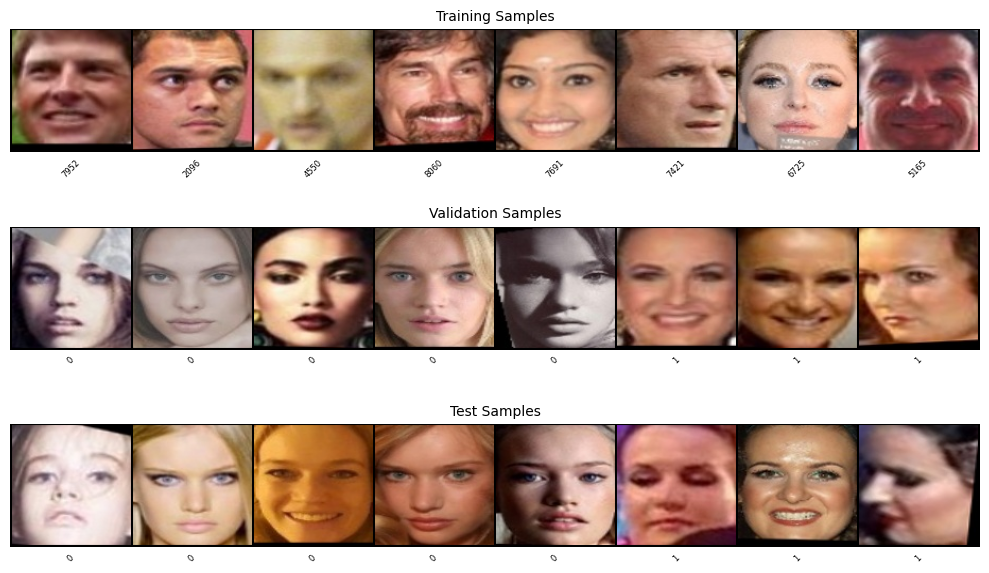

In [21]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

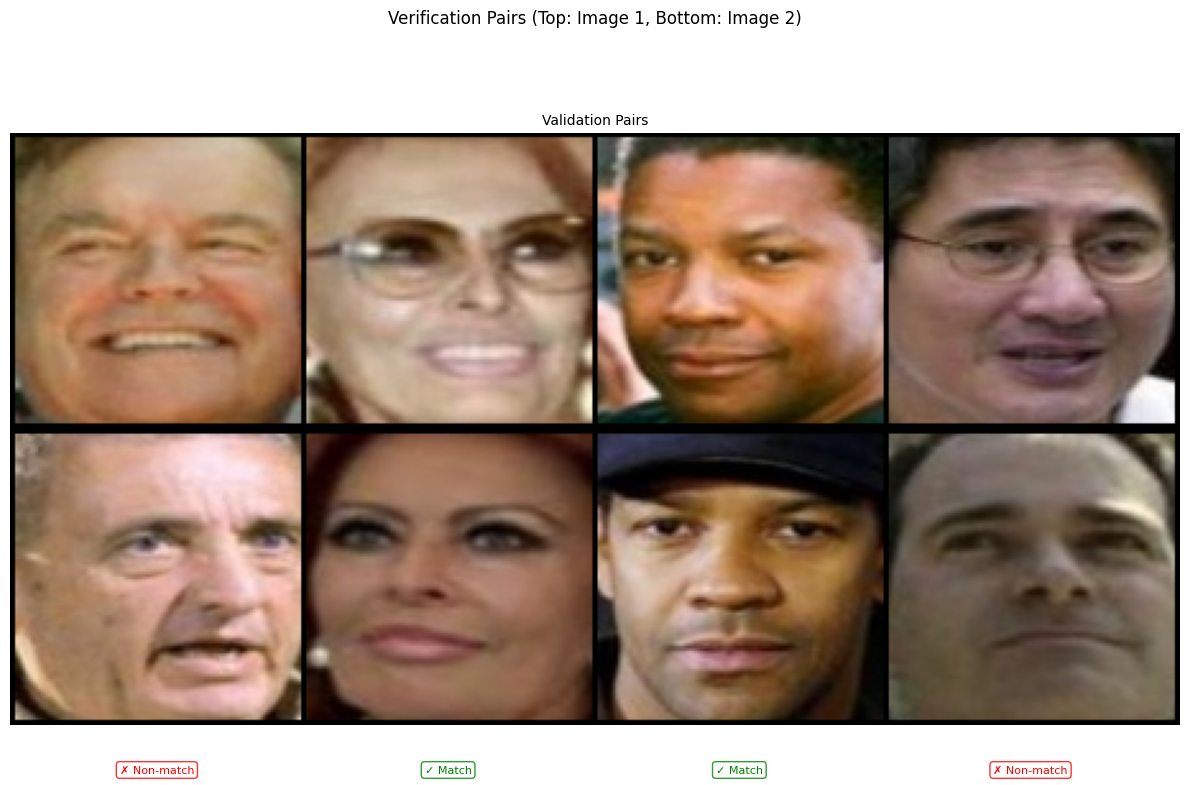

In [22]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [23]:
# TODO: Fill out the model definition below

##Attempt at ResNet-like architecture
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding = 1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.act1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = 1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                torch.nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.act1(out)
        return out

class CustomResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.act1 = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 256, layers[4], stride=2)
        self.layer6 = self._make_layer(block,  256, layers[5], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.dropout = torch.nn.Dropout(0.25)
        self.fc = torch.nn.Linear(256, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)

        feats = self.avgpool(x)
        feats = torch.flatten(feats, 1)
        feats = self.dropout(feats)
        out = self.fc(feats)

        return {"feats": feats, "out": out}
class Network(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 7, 4, padding = 3), 
            torch.nn.BatchNorm2d(64), 
            torch.nn.ReLU(),
            # torch.nn.Dropout2d(0.2), 
            
            torch.nn.Conv2d(64, 128, 3, 2, padding = 1), 
            torch.nn.BatchNorm2d(128 ),
            torch.nn.ReLU(), 
            # torch.nn.Dropout2d(0.2),
            
            torch.nn.Conv2d(128, 256, 3, 2, padding = 1),
            torch.nn.BatchNorm2d(256 ), 
            torch.nn.ReLU(),
            # torch.nn.Dropout2d(0.2),
            
            torch.nn.Conv2d(256, 512, 3, 2, padding = 1),
            torch.nn.BatchNorm2d(512 ), 
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            
            torch.nn.Conv2d(512, 1024, 3, 2, padding = 1),
            torch.nn.BatchNorm2d(1024 ), 
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            
            torch.nn.Conv2d(1024, 1024, 3, 2, padding = 1),
            torch.nn.BatchNorm2d(1024 ), 
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),

            # torch.nn.Conv2d(2048, 2048, 3, 2, padding = 1),
            # torch.nn.BatchNorm2d(2048 ), 
            # torch.nn.ReLU(),
            # torch.nn.Dropout2d(0.2),
            # torch.nn.Conv2d(2048, 2048, 3, 2, padding = 1),
            # torch.nn.BatchNorm2d(2048 ), 
            # torch.nn.ReLU(),
            # torch.nn.Dropout2d(0.2),
            
            torch.nn.AdaptiveAvgPool2d(1)
            # TODO: Implement 5-layer CNN as described in FAQ for early submission

            )

        self.cls_layer = torch.nn.Linear(1024, num_classes) #TODO Final classification layer

    def forward(self, x):

        feats = self.backbone(x)
        feats = torch.flatten(feats, 1)
        out = self.cls_layer(feats)

        return {"feats": feats, "out": out}

# Initialize your model
# model = Network(num_classes=config['num_classes']).to(DEVICE)
# checkpoint = torch.load(os.path.join(location, 'best_cls.pth'), map_location='cuda', weights_only = False)
# model2.load_state_dict(checkpoint['model_state_dict'])
# # optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
# # scheduler2.load_state_dict(checkpoint['scheduler_state_dict'])
# e = checkpoint['epoch'] + 1
# metrics2 = checkpoint['metric']
model = CustomResNet(BasicBlock, [3, 4, 6, 3, 2, 2], num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
       BasicBlock-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,928
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [24]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = config['lr'], weight_decay = 1E-4) # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,        # number of epochs before first restart
    T_mult=2,      # cycle length grows by factor of 2 after each restart
    eta_min=1e-6   # min learning rate
) # TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Metrics

In [25]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [27]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [28]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [29]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [30]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [31]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [32]:
wandb.login(key="cf6d7f096f22962de03aa3fb7237fc654bfe1350") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/sidas/.netrc
wandb: Currently logged in as: sashok2 (sashok2-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [33]:
# Create your wandb run
run = wandb.init(
    name = "attempt_resnet", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Checkpointing and Loading Model

In [34]:
import os
checkpoint_dir = config['checkpoint_dir']
location = f"{checkpoint_dir}"
# Create the directory if it doesn't exist
os.makedirs(f"{checkpoint_dir}", exist_ok=True)

In [35]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [36]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e,config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(location, 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(location, 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(location, 'best_ret.pth'))
            wandb.save(os.path.join(location, 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|                                                                                                  …


Epoch 1/100: 
Train Cls. Acc 0.0125%	 Train Cls. Loss 9.0745	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 0.0301%	 Val Cls. Loss 8.9611


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 59.5, 'EER': 43.17615418505099, 'AUC': 59.400045614779195, 'TPRs': [('TPR@FPR=1e-4', 0.012439918533604889), ('TPR@FPR=5e-4', 0.062199592668024446), ('TPR@FPR=1e-3', 0.12439918533604889), ('TPR@FPR=5e-3', 0.6219959266802444), ('TPR@FPR=5e-2', 10.183299389002038)]}
Val Ret. Acc 59.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 2/100


Train:   0%|                                                                                                  …


Epoch 2/100: 
Train Cls. Acc 0.0315%	 Train Cls. Loss 8.7658	 Learning Rate 0.0018


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 0.0741%	 Val Cls. Loss 8.3209


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 74.5, 'EER': 26.719056974517603, 'AUC': 80.87160239917733, 'TPRs': [('TPR@FPR=1e-4', 1.0183299389002036), ('TPR@FPR=5e-4', 1.0183299389002036), ('TPR@FPR=1e-3', 1.0183299389002036), ('TPR@FPR=5e-3', 4.0733197556008145), ('TPR@FPR=5e-2', 24.643584521384927)]}
Val Ret. Acc 74.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/100


Train:   0%|                                                                                                  …


Epoch 3/100: 
Train Cls. Acc 0.0904%	 Train Cls. Loss 8.1202	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 0.2708%	 Val Cls. Loss 7.6690


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 82.2, 'EER': 18.664047151381457, 'AUC': 89.11007166321887, 'TPRs': [('TPR@FPR=1e-4', 3.054989816700611), ('TPR@FPR=5e-4', 3.054989816700611), ('TPR@FPR=1e-3', 3.054989816700611), ('TPR@FPR=5e-3', 5.4989816700611), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 82.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/100


Train:   0%|                                                                                                  …


Epoch 4/100: 
Train Cls. Acc 0.2338%	 Train Cls. Loss 7.6827	 Learning Rate 0.0013


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 0.6134%	 Val Cls. Loss 7.3323


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 84.5, 'EER': 16.089613034623103, 'AUC': 90.81622445672397, 'TPRs': [('TPR@FPR=1e-4', 12.219959266802444), ('TPR@FPR=5e-4', 12.219959266802444), ('TPR@FPR=1e-3', 12.219959266802444), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 52.74949083503056)]}
Val Ret. Acc 84.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/100


Train:   0%|                                                                                                  …


Epoch 5/100: 
Train Cls. Acc 0.4431%	 Train Cls. Loss 7.3793	 Learning Rate 0.0010


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 1.0833%	 Val Cls. Loss 7.3966


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 82.6, 'EER': 17.718940936864623, 'AUC': 89.86351577911243, 'TPRs': [('TPR@FPR=1e-4', 8.146639511201629), ('TPR@FPR=5e-4', 8.146639511201629), ('TPR@FPR=1e-3', 8.146639511201629), ('TPR@FPR=5e-3', 8.350305498981669), ('TPR@FPR=5e-2', 57.63747454175153)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best classification model

Epoch 6/100


Train:   0%|                                                                                                  …


Epoch 6/100: 
Train Cls. Acc 0.6736%	 Train Cls. Loss 7.1727	 Learning Rate 0.0007


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 1.6528%	 Val Cls. Loss 7.3064


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 85.5, 'EER': 14.734774066822807, 'AUC': 91.45443123572036, 'TPRs': [('TPR@FPR=1e-4', 14.867617107942973), ('TPR@FPR=5e-4', 14.867617107942973), ('TPR@FPR=1e-3', 14.867617107942973), ('TPR@FPR=5e-3', 32.79022403258656), ('TPR@FPR=5e-2', 63.13645621181263)]}
Val Ret. Acc 85.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/100


Train:   0%|                                                                                                  …


Epoch 7/100: 
Train Cls. Acc 0.9679%	 Train Cls. Loss 6.9427	 Learning Rate 0.0004


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 2.3218%	 Val Cls. Loss 8.1749


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 85.3, 'EER': 15.520628683774266, 'AUC': 91.67870390006361, 'TPRs': [('TPR@FPR=1e-4', 5.091649694501019), ('TPR@FPR=5e-4', 5.091649694501019), ('TPR@FPR=1e-3', 5.091649694501019), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 64.96945010183299)]}
Val Ret. Acc 85.3000%
Saved epoch model
Saved best classification model

Epoch 8/100


Train:   0%|                                                                                                  …


Epoch 8/100: 
Train Cls. Acc 1.2912%	 Train Cls. Loss 6.7573	 Learning Rate 0.0002


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 3.0023%	 Val Cls. Loss 7.5790


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 85.5, 'EER': 15.520628683677964, 'AUC': 91.68170487237866, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 34.21588594704684), ('TPR@FPR=5e-2', 62.52545824847251)]}
Val Ret. Acc 85.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/100


Train:   0%|                                                                                                  …


Epoch 9/100: 
Train Cls. Acc 1.5451%	 Train Cls. Loss 6.6355	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 3.3365%	 Val Cls. Loss 7.7084


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 85.7, 'EER': 14.86761710794301, 'AUC': 91.93018538006314, 'TPRs': [('TPR@FPR=1e-4', 9.572301425661914), ('TPR@FPR=5e-4', 9.572301425661914), ('TPR@FPR=1e-3', 9.572301425661914), ('TPR@FPR=5e-3', 38.289205702647656), ('TPR@FPR=5e-2', 69.4501018329939)]}
Val Ret. Acc 85.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/100


Train:   0%|                                                                                                  …


Epoch 10/100: 
Train Cls. Acc 1.7025%	 Train Cls. Loss 6.5666	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 3.4268%	 Val Cls. Loss 12.9413


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 85.5, 'EER': 15.324165029547776, 'AUC': 91.57366986903756, 'TPRs': [('TPR@FPR=1e-4', 7.942973523421588), ('TPR@FPR=5e-4', 7.942973523421588), ('TPR@FPR=1e-3', 7.942973523421588), ('TPR@FPR=5e-3', 41.34419551934827), ('TPR@FPR=5e-2', 66.19144602851324)]}
Val Ret. Acc 85.5000%
Saved epoch model
Saved best classification model

Epoch 11/100


Train:   0%|                                                                                                  …


Epoch 11/100: 
Train Cls. Acc 1.3220%	 Train Cls. Loss 6.8300	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 3.4722%	 Val Cls. Loss 7.4295


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 86.7, 'EER': 13.555992141458924, 'AUC': 93.32143614531108, 'TPRs': [('TPR@FPR=1e-4', 20.162932790224033), ('TPR@FPR=5e-4', 20.162932790224033), ('TPR@FPR=1e-3', 20.162932790224033), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 71.4867617107943)]}
Val Ret. Acc 86.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/100


Train:   0%|                                                                                                  …


Epoch 12/100: 
Train Cls. Acc 1.9249%	 Train Cls. Loss 6.6115	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 4.3241%	 Val Cls. Loss 11.2197


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 86.4, 'EER': 13.849287169043107, 'AUC': 91.83955601614923, 'TPRs': [('TPR@FPR=1e-4', 19.144602851323828), ('TPR@FPR=5e-4', 19.144602851323828), ('TPR@FPR=1e-3', 19.144602851323828), ('TPR@FPR=5e-3', 24.236252545824847), ('TPR@FPR=5e-2', 68.43177189409369)]}
Val Ret. Acc 86.4000%
Saved epoch model
Saved best classification model

Epoch 13/100


Train:   0%|                                                                                                  …


Epoch 13/100: 
Train Cls. Acc 2.5527%	 Train Cls. Loss 6.4439	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 6.0000%	 Val Cls. Loss 7.8586


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 87.4, 'EER': 13.034623217922602, 'AUC': 93.70315982378291, 'TPRs': [('TPR@FPR=1e-4', 16.4969450101833), ('TPR@FPR=5e-4', 16.4969450101833), ('TPR@FPR=1e-3', 16.4969450101833), ('TPR@FPR=5e-3', 29.735234215885946), ('TPR@FPR=5e-2', 68.43177189409369)]}
Val Ret. Acc 87.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/100


Train:   0%|                                                                                                  …


Epoch 14/100: 
Train Cls. Acc 3.5372%	 Train Cls. Loss 6.2071	 Learning Rate 0.0018


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 6.8559%	 Val Cls. Loss 7.5513


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 87.4, 'EER': 12.627291242362526, 'AUC': 92.8252753892261, 'TPRs': [('TPR@FPR=1e-4', 23.014256619144604), ('TPR@FPR=5e-4', 23.014256619144604), ('TPR@FPR=1e-3', 23.014256619144604), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 65.37678207739307)]}
Val Ret. Acc 87.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/100


Train:   0%|                                                                                                  …


Epoch 15/100: 
Train Cls. Acc 4.5679%	 Train Cls. Loss 6.0154	 Learning Rate 0.0017


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 8.3689%	 Val Cls. Loss 7.8124


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 86.7, 'EER': 13.645621181262731, 'AUC': 92.94751499485834, 'TPRs': [('TPR@FPR=1e-4', 12.627291242362526), ('TPR@FPR=5e-4', 12.627291242362526), ('TPR@FPR=1e-3', 12.627291242362526), ('TPR@FPR=5e-3', 25.661914460285136), ('TPR@FPR=5e-2', 65.9877800407332)]}
Val Ret. Acc 86.7000%
Saved epoch model
Saved best classification model

Epoch 16/100


Train:   0%|                                                                                                  …


Epoch 16/100: 
Train Cls. Acc 5.2295%	 Train Cls. Loss 5.9169	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 8.9337%	 Val Cls. Loss 12.7097


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 87.2, 'EER': 13.163064833029104, 'AUC': 93.23100684621818, 'TPRs': [('TPR@FPR=1e-4', 35.437881873727086), ('TPR@FPR=5e-4', 35.437881873727086), ('TPR@FPR=1e-3', 35.437881873727086), ('TPR@FPR=5e-3', 47.04684317718941), ('TPR@FPR=5e-2', 66.80244399185335)]}
Val Ret. Acc 87.2000%
Saved epoch model
Saved best classification model

Epoch 17/100


Train:   0%|                                                                                                  …


Epoch 17/100: 
Train Cls. Acc 6.5747%	 Train Cls. Loss 5.7103	 Learning Rate 0.0015


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 12.0749%	 Val Cls. Loss 5.6552


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 87.9, 'EER': 12.573673870303075, 'AUC': 93.98805212888975, 'TPRs': [('TPR@FPR=1e-4', 35.03054989816701), ('TPR@FPR=5e-4', 35.03054989816701), ('TPR@FPR=1e-3', 35.03054989816701), ('TPR@FPR=5e-3', 39.71486761710794), ('TPR@FPR=5e-2', 71.4867617107943)]}
Val Ret. Acc 87.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 18/100


Train:   0%|                                                                                                  …


Epoch 18/100: 
Train Cls. Acc 7.9815%	 Train Cls. Loss 5.5210	 Learning Rate 0.0013


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 14.0379%	 Val Cls. Loss 6.6878


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.9, 'EER': 11.201629327938694, 'AUC': 94.57144114693162, 'TPRs': [('TPR@FPR=1e-4', 36.86354378818738), ('TPR@FPR=5e-4', 36.86354378818738), ('TPR@FPR=1e-3', 36.86354378818738), ('TPR@FPR=5e-3', 44.39918533604888), ('TPR@FPR=5e-2', 76.57841140529531)]}
Val Ret. Acc 88.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 19/100


Train:   0%|                                                                                                  …


Epoch 19/100: 
Train Cls. Acc 9.5379%	 Train Cls. Loss 5.3134	 Learning Rate 0.0012


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 15.4661%	 Val Cls. Loss 7.8363


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.3, 'EER': 11.001964636617851, 'AUC': 95.38690535733578, 'TPRs': [('TPR@FPR=1e-4', 17.311608961303463), ('TPR@FPR=5e-4', 17.311608961303463), ('TPR@FPR=1e-3', 17.311608961303463), ('TPR@FPR=5e-3', 31.771894093686353), ('TPR@FPR=5e-2', 76.78207739307535)]}
Val Ret. Acc 89.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 20/100


Train:   0%|                                                                                                  …


Epoch 20/100: 
Train Cls. Acc 10.4743%	 Train Cls. Loss 5.2172	 Learning Rate 0.0010


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 15.1860%	 Val Cls. Loss 8.1135


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.0, 'EER': 12.219959266802451, 'AUC': 95.0792056626347, 'TPRs': [('TPR@FPR=1e-4', 40.936863543788185), ('TPR@FPR=5e-4', 40.936863543788185), ('TPR@FPR=1e-3', 40.936863543788185), ('TPR@FPR=5e-3', 51.12016293279022), ('TPR@FPR=5e-2', 74.74541751527495)]}
Val Ret. Acc 88.0000%
Saved epoch model

Epoch 21/100


Train:   0%|                                                                                                  …


Epoch 21/100: 
Train Cls. Acc 11.8913%	 Train Cls. Loss 5.0703	 Learning Rate 0.0008


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 18.6938%	 Val Cls. Loss 10.8664


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.5, 'EER': 11.787819253292692, 'AUC': 95.33648902244327, 'TPRs': [('TPR@FPR=1e-4', 28.716904276985744), ('TPR@FPR=5e-4', 28.716904276985744), ('TPR@FPR=1e-3', 28.716904276985744), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 79.63340122199592)]}
Val Ret. Acc 88.5000%
Saved epoch model
Saved best classification model

Epoch 22/100


Train:   0%|                                                                                                  …


Epoch 22/100: 
Train Cls. Acc 13.5836%	 Train Cls. Loss 4.8890	 Learning Rate 0.0007


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 20.1831%	 Val Cls. Loss 7.0342


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.0, 'EER': 11.405295315682283, 'AUC': 95.16243262817152, 'TPRs': [('TPR@FPR=1e-4', 15.885947046843176), ('TPR@FPR=5e-4', 15.885947046843176), ('TPR@FPR=1e-3', 15.885947046843176), ('TPR@FPR=5e-3', 33.401221995926676), ('TPR@FPR=5e-2', 78.61507128309573)]}
Val Ret. Acc 89.0000%
Saved epoch model
Saved best classification model

Epoch 23/100


Train:   0%|                                                                                                  …


Epoch 23/100: 
Train Cls. Acc 14.7890%	 Train Cls. Loss 4.7801	 Learning Rate 0.0005


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 20.8359%	 Val Cls. Loss 17.9906


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.2, 'EER': 11.405295315669155, 'AUC': 94.511021570989, 'TPRs': [('TPR@FPR=1e-4', 19.75560081466395), ('TPR@FPR=5e-4', 19.75560081466395), ('TPR@FPR=1e-3', 19.75560081466395), ('TPR@FPR=5e-3', 36.04887983706721), ('TPR@FPR=5e-2', 74.74541751527495)]}
Val Ret. Acc 89.2000%
Saved epoch model
Saved best classification model

Epoch 24/100


Train:   0%|                                                                                                  …


Epoch 24/100: 
Train Cls. Acc 16.1759%	 Train Cls. Loss 4.6395	 Learning Rate 0.0004


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 22.2925%	 Val Cls. Loss 8.9098


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.5, 'EER': 11.608961303462323, 'AUC': 94.95716612182346, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 47.657841140529534), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 88.5000%
Saved epoch model
Saved best classification model

Epoch 25/100


Train:   0%|                                                                                                  …


Epoch 25/100: 
Train Cls. Acc 17.2279%	 Train Cls. Loss 4.5288	 Learning Rate 0.0003


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 23.0596%	 Val Cls. Loss 14.4576


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.5, 'EER': 12.830957230142648, 'AUC': 93.9226309324221, 'TPRs': [('TPR@FPR=1e-4', 28.920570264765782), ('TPR@FPR=5e-4', 28.920570264765782), ('TPR@FPR=1e-3', 28.920570264765782), ('TPR@FPR=5e-3', 48.06517311608962), ('TPR@FPR=5e-2', 78.81873727087576)]}
Val Ret. Acc 88.5000%
Saved epoch model
Saved best classification model

Epoch 26/100


Train:   0%|                                                                                                  …


Epoch 26/100: 
Train Cls. Acc 18.2517%	 Train Cls. Loss 4.4374	 Learning Rate 0.0002


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 23.9123%	 Val Cls. Loss 14.2959


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.5, 'EER': 11.81262729122933, 'AUC': 95.09381039456784, 'TPRs': [('TPR@FPR=1e-4', 42.56619144602851), ('TPR@FPR=5e-4', 42.56619144602851), ('TPR@FPR=1e-3', 42.56619144602851), ('TPR@FPR=5e-3', 45.824847250509166), ('TPR@FPR=5e-2', 80.65173116089613)]}
Val Ret. Acc 88.5000%
Saved epoch model
Saved best classification model

Epoch 27/100


Train:   0%|                                                                                                  …


Epoch 27/100: 
Train Cls. Acc 19.0766%	 Train Cls. Loss 4.3615	 Learning Rate 0.0001


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 24.4068%	 Val Cls. Loss 9.5475


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.6, 'EER': 11.198428290712277, 'AUC': 95.68020038492472, 'TPRs': [('TPR@FPR=1e-4', 39.307535641547865), ('TPR@FPR=5e-4', 39.307535641547865), ('TPR@FPR=1e-3', 39.307535641547865), ('TPR@FPR=5e-3', 48.26883910386965), ('TPR@FPR=5e-2', 80.24439918533605)]}
Val Ret. Acc 89.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 28/100


Train:   0%|                                                                                                  …


Epoch 28/100: 
Train Cls. Acc 19.7505%	 Train Cls. Loss 4.3000	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 24.6252%	 Val Cls. Loss 11.6564


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.7, 'EER': 10.609037328147195, 'AUC': 95.47133271179864, 'TPRs': [('TPR@FPR=1e-4', 44.806517311608964), ('TPR@FPR=5e-4', 44.806517311608964), ('TPR@FPR=1e-3', 44.806517311608964), ('TPR@FPR=5e-3', 51.73116089613035), ('TPR@FPR=5e-2', 80.24439918533605)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 29/100


Train:   0%|                                                                                                  …


Epoch 29/100: 
Train Cls. Acc 20.1997%	 Train Cls. Loss 4.2664	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 24.8544%	 Val Cls. Loss 10.6836


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.7, 'EER': 10.794297352342161, 'AUC': 95.52695073203718, 'TPRs': [('TPR@FPR=1e-4', 45.41751527494908), ('TPR@FPR=5e-4', 45.41751527494908), ('TPR@FPR=1e-3', 45.41751527494908), ('TPR@FPR=5e-3', 49.89816700610998), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 30/100


Train:   0%|                                                                                                  …


Epoch 30/100: 
Train Cls. Acc 20.3784%	 Train Cls. Loss 4.2466	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 24.8752%	 Val Cls. Loss 14.0232


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.8, 'EER': 10.805500982356165, 'AUC': 95.53895462129731, 'TPRs': [('TPR@FPR=1e-4', 42.76985743380855), ('TPR@FPR=5e-4', 42.76985743380855), ('TPR@FPR=1e-3', 42.76985743380855), ('TPR@FPR=5e-3', 49.287169042769854), ('TPR@FPR=5e-2', 81.4663951120163)]}
Val Ret. Acc 89.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 31/100


Train:   0%|                                                                                                  …


Epoch 31/100: 
Train Cls. Acc 15.1183%	 Train Cls. Loss 4.7679	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 18.3174%	 Val Cls. Loss 21.8769


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.8, 'EER': 12.016293279022408, 'AUC': 94.70708509557096, 'TPRs': [('TPR@FPR=1e-4', 37.67820773930753), ('TPR@FPR=5e-4', 37.67820773930753), ('TPR@FPR=1e-3', 37.67820773930753), ('TPR@FPR=5e-3', 46.63951120162933), ('TPR@FPR=5e-2', 79.0224032586558)]}
Val Ret. Acc 88.8000%
Saved epoch model

Epoch 32/100


Train:   0%|                                                                                                  …


Epoch 32/100: 
Train Cls. Acc 16.5557%	 Train Cls. Loss 4.6626	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 23.1232%	 Val Cls. Loss 7.1865


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.7, 'EER': 11.608961303439456, 'AUC': 95.6677963660226, 'TPRs': [('TPR@FPR=1e-4', 52.74949083503056), ('TPR@FPR=5e-4', 52.74949083503056), ('TPR@FPR=1e-3', 52.74949083503056), ('TPR@FPR=5e-3', 61.91446028513238), ('TPR@FPR=5e-2', 78.00407331975559)]}
Val Ret. Acc 88.7000%
Saved epoch model

Epoch 33/100


Train:   0%|                                                                                                  …


Epoch 33/100: 
Train Cls. Acc 18.1590%	 Train Cls. Loss 4.5199	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 25.8561%	 Val Cls. Loss 5.6932


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.7, 'EER': 10.997963340120847, 'AUC': 95.97989748678573, 'TPRs': [('TPR@FPR=1e-4', 42.973523421588595), ('TPR@FPR=5e-4', 42.973523421588595), ('TPR@FPR=1e-3', 42.973523421588595), ('TPR@FPR=5e-3', 49.287169042769854), ('TPR@FPR=5e-2', 79.42973523421588)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model

Epoch 34/100


Train:   0%|                                                                                                  …


Epoch 34/100: 
Train Cls. Acc 20.3689%	 Train Cls. Loss 4.3416	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 28.4056%	 Val Cls. Loss 7.3466


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.8, 'EER': 10.38696537675143, 'AUC': 95.70220751523493, 'TPRs': [('TPR@FPR=1e-4', 53.97148676171079), ('TPR@FPR=5e-4', 53.97148676171079), ('TPR@FPR=1e-3', 53.97148676171079), ('TPR@FPR=5e-3', 59.26680244399185), ('TPR@FPR=5e-2', 82.28105906313645)]}
Val Ret. Acc 89.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 35/100


Train:   0%|                                                                                                  …


Epoch 35/100: 
Train Cls. Acc 21.9384%	 Train Cls. Loss 4.2357	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 29.6385%	 Val Cls. Loss 4.9652


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.9, 'EER': 9.775967413442295, 'AUC': 96.35241818349147, 'TPRs': [('TPR@FPR=1e-4', 53.360488798370675), ('TPR@FPR=5e-4', 53.360488798370675), ('TPR@FPR=1e-3', 53.360488798370675), ('TPR@FPR=5e-3', 60.28513238289206), ('TPR@FPR=5e-2', 85.33604887983707)]}
Val Ret. Acc 90.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 36/100


Train:   0%|                                                                                                  …


Epoch 36/100: 
Train Cls. Acc 23.6696%	 Train Cls. Loss 4.1130	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 29.9178%	 Val Cls. Loss 6.8970


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.3, 'EER': 9.979633401222, 'AUC': 95.88066533556872, 'TPRs': [('TPR@FPR=1e-4', 44.39918533604888), ('TPR@FPR=5e-4', 44.39918533604888), ('TPR@FPR=1e-3', 44.39918533604888), ('TPR@FPR=5e-3', 56.61914460285132), ('TPR@FPR=5e-2', 81.4663951120163)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model

Epoch 37/100


Train:   0%|                                                                                                  …


Epoch 37/100: 
Train Cls. Acc 25.6170%	 Train Cls. Loss 3.9555	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 30.1550%	 Val Cls. Loss 6.5176


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.6, 'EER': 9.8231827112113, 'AUC': 96.07792924907672, 'TPRs': [('TPR@FPR=1e-4', 44.602851323828915), ('TPR@FPR=5e-4', 44.602851323828915), ('TPR@FPR=1e-3', 44.602851323828915), ('TPR@FPR=5e-3', 52.74949083503056), ('TPR@FPR=5e-2', 81.87372708757637)]}
Val Ret. Acc 90.6000%
Saved epoch model
Saved best classification model

Epoch 38/100


Train:   0%|                                                                                                  …


Epoch 38/100: 
Train Cls. Acc 27.2316%	 Train Cls. Loss 3.8433	 Learning Rate 0.0018


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 33.9990%	 Val Cls. Loss 6.8249


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.5, 'EER': 9.775967413441952, 'AUC': 95.86025872382652, 'TPRs': [('TPR@FPR=1e-4', 22.403258655804482), ('TPR@FPR=5e-4', 22.403258655804482), ('TPR@FPR=1e-3', 22.403258655804482), ('TPR@FPR=5e-3', 43.38085539714868), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 90.5000%
Saved epoch model
Saved best classification model

Epoch 39/100


Train:   0%|                                                                                                  …


Epoch 39/100: 
Train Cls. Acc 28.3073%	 Train Cls. Loss 3.7644	 Learning Rate 0.0018


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 35.7189%	 Val Cls. Loss 7.7628


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.6, 'EER': 9.979633401222381, 'AUC': 96.0587230262605, 'TPRs': [('TPR@FPR=1e-4', 45.41751527494908), ('TPR@FPR=5e-4', 45.41751527494908), ('TPR@FPR=1e-3', 45.41751527494908), ('TPR@FPR=5e-3', 52.74949083503056), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 90.6000%
Saved epoch model
Saved best classification model

Epoch 40/100


Train:   0%|                                                                                                  …


Epoch 40/100: 
Train Cls. Acc 30.1193%	 Train Cls. Loss 3.6311	 Learning Rate 0.0017


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 37.2682%	 Val Cls. Loss 12.6837


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.4, 'EER': 8.64440078593123, 'AUC': 96.8469784210084, 'TPRs': [('TPR@FPR=1e-4', 36.456211812627295), ('TPR@FPR=5e-4', 36.456211812627295), ('TPR@FPR=1e-3', 36.456211812627295), ('TPR@FPR=5e-3', 49.69450101832994), ('TPR@FPR=5e-2', 86.15071283095723)]}
Val Ret. Acc 91.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 41/100


Train:   0%|                                                                                                  …


Epoch 41/100: 
Train Cls. Acc 31.7008%	 Train Cls. Loss 3.5315	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 37.5407%	 Val Cls. Loss 7.3527


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.5, 'EER': 10.019646365481282, 'AUC': 96.03271459953024, 'TPRs': [('TPR@FPR=1e-4', 40.73319755600815), ('TPR@FPR=5e-4', 40.73319755600815), ('TPR@FPR=1e-3', 40.73319755600815), ('TPR@FPR=5e-3', 52.138492871690424), ('TPR@FPR=5e-2', 84.11405295315683)]}
Val Ret. Acc 90.5000%
Saved epoch model
Saved best classification model

Epoch 42/100


Train:   0%|                                                                                                  …


Epoch 42/100: 
Train Cls. Acc 33.4109%	 Train Cls. Loss 3.4145	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 37.3709%	 Val Cls. Loss 14.4955


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.6, 'EER': 9.775967413441911, 'AUC': 96.35161792420746, 'TPRs': [('TPR@FPR=1e-4', 48.472505091649694), ('TPR@FPR=5e-4', 48.472505091649694), ('TPR@FPR=1e-3', 48.472505091649694), ('TPR@FPR=5e-3', 54.58248472505092), ('TPR@FPR=5e-2', 83.91038696537679)]}
Val Ret. Acc 90.6000%
Saved epoch model

Epoch 43/100


Train:   0%|                                                                                                  …


Epoch 43/100: 
Train Cls. Acc 35.3051%	 Train Cls. Loss 3.2840	 Learning Rate 0.0015


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 40.9403%	 Val Cls. Loss 6.0634


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.4, 'EER': 9.430255402768314, 'AUC': 96.15935563122451, 'TPRs': [('TPR@FPR=1e-4', 48.06517311608962), ('TPR@FPR=5e-4', 48.06517311608962), ('TPR@FPR=1e-3', 48.06517311608962), ('TPR@FPR=5e-3', 52.74949083503056), ('TPR@FPR=5e-2', 87.57637474541752)]}
Val Ret. Acc 91.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 44/100


Train:   0%|                                                                                                  …


Epoch 44/100: 
Train Cls. Acc 37.0300%	 Train Cls. Loss 3.1695	 Learning Rate 0.0015


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 41.3326%	 Val Cls. Loss 6.1089


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.9, 'EER': 8.644400785791525, 'AUC': 96.5572845601975, 'TPRs': [('TPR@FPR=1e-4', 46.84317718940937), ('TPR@FPR=5e-4', 46.84317718940937), ('TPR@FPR=1e-3', 46.84317718940937), ('TPR@FPR=5e-3', 52.138492871690424), ('TPR@FPR=5e-2', 87.9837067209776)]}
Val Ret. Acc 91.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 45/100


Train:   0%|                                                                                                  …


Epoch 45/100: 
Train Cls. Acc 38.9464%	 Train Cls. Loss 3.0359	 Learning Rate 0.0014


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 42.4275%	 Val Cls. Loss 7.5694


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.6, 'EER': 9.823182711025884, 'AUC': 96.25238577299045, 'TPRs': [('TPR@FPR=1e-4', 47.86150712830957), ('TPR@FPR=5e-4', 47.86150712830957), ('TPR@FPR=1e-3', 47.86150712830957), ('TPR@FPR=5e-3', 52.54582484725051), ('TPR@FPR=5e-2', 86.55804480651732)]}
Val Ret. Acc 91.6000%
Saved epoch model
Saved best classification model

Epoch 46/100


Train:   0%|                                                                                                  …


Epoch 46/100: 
Train Cls. Acc 40.4120%	 Train Cls. Loss 2.9540	 Learning Rate 0.0013


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 41.7021%	 Val Cls. Loss 10.8662


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.6, 'EER': 9.62671905714002, 'AUC': 94.85993461881648, 'TPRs': [('TPR@FPR=1e-4', 48.06517311608962), ('TPR@FPR=5e-4', 48.06517311608962), ('TPR@FPR=1e-3', 48.06517311608962), ('TPR@FPR=5e-3', 57.841140529531565), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 90.6000%
Saved epoch model

Epoch 47/100


Train:   0%|                                                                                                  …


Epoch 47/100: 
Train Cls. Acc 42.4250%	 Train Cls. Loss 2.8148	 Learning Rate 0.0012


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 43.0641%	 Val Cls. Loss 5.8127


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.3, 'EER': 10.590631364531488, 'AUC': 94.79271283895982, 'TPRs': [('TPR@FPR=1e-4', 43.38085539714868), ('TPR@FPR=5e-4', 43.38085539714868), ('TPR@FPR=1e-3', 43.38085539714868), ('TPR@FPR=5e-3', 55.80448065173116), ('TPR@FPR=5e-2', 84.11405295315683)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model

Epoch 48/100


Train:   0%|                                                                                                  …


Epoch 48/100: 
Train Cls. Acc 44.1597%	 Train Cls. Loss 2.7008	 Learning Rate 0.0012


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 44.8997%	 Val Cls. Loss 5.7523


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.8, 'EER': 8.8408644400412, 'AUC': 95.57656680764566, 'TPRs': [('TPR@FPR=1e-4', 36.456211812627295), ('TPR@FPR=5e-4', 36.456211812627295), ('TPR@FPR=1e-3', 36.456211812627295), ('TPR@FPR=5e-3', 41.34419551934827), ('TPR@FPR=5e-2', 85.74338085539715)]}
Val Ret. Acc 91.8000%
Saved epoch model
Saved best classification model

Epoch 49/100


Train:   0%|                                                                                                  …


Epoch 49/100: 
Train Cls. Acc 46.1168%	 Train Cls. Loss 2.5684	 Learning Rate 0.0011


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 44.5190%	 Val Cls. Loss 8.7299


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.9, 'EER': 8.251473477542918, 'AUC': 96.49606472497089, 'TPRs': [('TPR@FPR=1e-4', 44.39918533604888), ('TPR@FPR=5e-4', 44.39918533604888), ('TPR@FPR=1e-3', 44.39918533604888), ('TPR@FPR=5e-3', 58.65580448065173), ('TPR@FPR=5e-2', 85.94704684317719)]}
Val Ret. Acc 91.9000%
Saved epoch model
Saved best retrieval model

Epoch 50/100


Train:   0%|                                                                                                  …


Epoch 50/100: 
Train Cls. Acc 47.6079%	 Train Cls. Loss 2.4853	 Learning Rate 0.0010


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 45.1558%	 Val Cls. Loss 5.3379


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.8, 'EER': 9.233791748483227, 'AUC': 96.45245059399244, 'TPRs': [('TPR@FPR=1e-4', 37.06720977596741), ('TPR@FPR=5e-4', 37.06720977596741), ('TPR@FPR=1e-3', 37.06720977596741), ('TPR@FPR=5e-3', 53.56415478615071), ('TPR@FPR=5e-2', 87.78004073319755)]}
Val Ret. Acc 91.8000%
Saved epoch model
Saved best classification model

Epoch 51/100


Train:   0%|                                                                                                  …


Epoch 51/100: 
Train Cls. Acc 48.9830%	 Train Cls. Loss 2.3933	 Learning Rate 0.0009


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 46.2267%	 Val Cls. Loss 8.3035


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.5, 'EER': 9.36863543788188, 'AUC': 96.5960971354719, 'TPRs': [('TPR@FPR=1e-4', 51.32382892057027), ('TPR@FPR=5e-4', 51.32382892057027), ('TPR@FPR=1e-3', 51.32382892057027), ('TPR@FPR=5e-3', 54.58248472505092), ('TPR@FPR=5e-2', 86.35437881873727)]}
Val Ret. Acc 91.5000%
Saved epoch model
Saved best classification model

Epoch 52/100


Train:   0%|                                                                                                  …


Epoch 52/100: 
Train Cls. Acc 50.5990%	 Train Cls. Loss 2.2902	 Learning Rate 0.0008


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 46.7423%	 Val Cls. Loss 8.0167


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 92.3, 'EER': 8.961303462321643, 'AUC': 96.6565167114145, 'TPRs': [('TPR@FPR=1e-4', 48.676171079429736), ('TPR@FPR=5e-4', 48.676171079429736), ('TPR@FPR=1e-3', 48.676171079429736), ('TPR@FPR=5e-3', 53.15682281059063), ('TPR@FPR=5e-2', 88.79837067209776)]}
Val Ret. Acc 92.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 53/100


Train:   0%|                                                                                                  …


Epoch 53/100: 
Train Cls. Acc 52.0994%	 Train Cls. Loss 2.1945	 Learning Rate 0.0008


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.1804%	 Val Cls. Loss 6.6660


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.4, 'EER': 9.23379174861613, 'AUC': 96.48486109499477, 'TPRs': [('TPR@FPR=1e-4', 49.490835030549896), ('TPR@FPR=5e-4', 49.490835030549896), ('TPR@FPR=1e-3', 49.490835030549896), ('TPR@FPR=5e-3', 52.953156822810584), ('TPR@FPR=5e-2', 86.55804480651732)]}
Val Ret. Acc 91.4000%
Saved epoch model
Saved best classification model

Epoch 54/100


Train:   0%|                                                                                                  …


Epoch 54/100: 
Train Cls. Acc 53.3996%	 Train Cls. Loss 2.1199	 Learning Rate 0.0007


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.0948%	 Val Cls. Loss 5.9753


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.6, 'EER': 8.757637474519154, 'AUC': 96.74014380659332, 'TPRs': [('TPR@FPR=1e-4', 31.568228105906314), ('TPR@FPR=5e-4', 31.568228105906314), ('TPR@FPR=1e-3', 31.568228105906314), ('TPR@FPR=5e-3', 51.12016293279022), ('TPR@FPR=5e-2', 86.35437881873727)]}
Val Ret. Acc 91.6000%
Saved epoch model

Epoch 55/100


Train:   0%|                                                                                                  …


Epoch 55/100: 
Train Cls. Acc 55.1139%	 Train Cls. Loss 2.0190	 Learning Rate 0.0006


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.2284%	 Val Cls. Loss 6.7798


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.1, 'EER': 9.23379174861333, 'AUC': 96.22757773518619, 'TPRs': [('TPR@FPR=1e-4', 39.71486761710794), ('TPR@FPR=5e-4', 39.71486761710794), ('TPR@FPR=1e-3', 39.71486761710794), ('TPR@FPR=5e-3', 59.26680244399185), ('TPR@FPR=5e-2', 84.928716904277)]}
Val Ret. Acc 91.1000%
Saved epoch model
Saved best classification model

Epoch 56/100


Train:   0%|                                                                                                  …


Epoch 56/100: 
Train Cls. Acc 56.4741%	 Train Cls. Loss 1.9416	 Learning Rate 0.0005


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 46.9683%	 Val Cls. Loss 7.7767


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.3, 'EER': 9.037328094206009, 'AUC': 96.1383488250193, 'TPRs': [('TPR@FPR=1e-4', 54.989816700610994), ('TPR@FPR=5e-4', 54.989816700610994), ('TPR@FPR=1e-3', 54.989816700610994), ('TPR@FPR=5e-3', 56.211812627291245), ('TPR@FPR=5e-2', 83.5030549898167)]}
Val Ret. Acc 91.3000%
Saved epoch model

Epoch 57/100


Train:   0%|                                                                                                  …


Epoch 57/100: 
Train Cls. Acc 57.5141%	 Train Cls. Loss 1.8803	 Learning Rate 0.0005


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.1205%	 Val Cls. Loss 8.5156


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.1, 'EER': 9.979633401222008, 'AUC': 95.46653115609456, 'TPRs': [('TPR@FPR=1e-4', 30.75356415478615), ('TPR@FPR=5e-4', 30.75356415478615), ('TPR@FPR=1e-3', 30.75356415478615), ('TPR@FPR=5e-3', 43.78818737270876), ('TPR@FPR=5e-2', 84.928716904277)]}
Val Ret. Acc 91.1000%
Saved epoch model

Epoch 58/100


Train:   0%|                                                                                                  …


Epoch 58/100: 
Train Cls. Acc 59.1294%	 Train Cls. Loss 1.7930	 Learning Rate 0.0004


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.7322%	 Val Cls. Loss 6.3796


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.0, 'EER': 9.368635437880068, 'AUC': 96.01630928420808, 'TPRs': [('TPR@FPR=1e-4', 47.86150712830957), ('TPR@FPR=5e-4', 47.86150712830957), ('TPR@FPR=1e-3', 47.86150712830957), ('TPR@FPR=5e-3', 54.78615071283096), ('TPR@FPR=5e-2', 83.09572301425662)]}
Val Ret. Acc 91.0000%
Saved epoch model
Saved best classification model

Epoch 59/100


Train:   0%|                                                                                                  …


Epoch 59/100: 
Train Cls. Acc 60.6933%	 Train Cls. Loss 1.7026	 Learning Rate 0.0004


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.4669%	 Val Cls. Loss 12.4801


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.6, 'EER': 9.823182711348526, 'AUC': 96.00830669136799, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 54.378818737270876), ('TPR@FPR=5e-2', 84.5213849287169)]}
Val Ret. Acc 90.6000%
Saved epoch model

Epoch 60/100


Train:   0%|                                                                                                  …


Epoch 60/100: 
Train Cls. Acc 61.5651%	 Train Cls. Loss 1.6559	 Learning Rate 0.0003


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.0355%	 Val Cls. Loss 11.6817


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.5, 'EER': 10.019646365460028, 'AUC': 95.80384044430396, 'TPRs': [('TPR@FPR=1e-4', 37.88187372708758), ('TPR@FPR=5e-4', 37.88187372708758), ('TPR@FPR=1e-3', 37.88187372708758), ('TPR@FPR=5e-3', 47.657841140529534), ('TPR@FPR=5e-2', 82.89205702647658)]}
Val Ret. Acc 90.5000%
Saved epoch model

Epoch 61/100


Train:   0%|                                                                                                  …


Epoch 61/100: 
Train Cls. Acc 62.6609%	 Train Cls. Loss 1.5969	 Learning Rate 0.0002


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.5022%	 Val Cls. Loss 10.4841


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.5, 'EER': 9.037328094243383, 'AUC': 96.21277293843204, 'TPRs': [('TPR@FPR=1e-4', 42.973523421588595), ('TPR@FPR=5e-4', 42.973523421588595), ('TPR@FPR=1e-3', 42.973523421588595), ('TPR@FPR=5e-3', 65.58044806517312), ('TPR@FPR=5e-2', 84.928716904277)]}
Val Ret. Acc 91.5000%
Saved epoch model

Epoch 62/100


Train:   0%|                                                                                                  …


Epoch 62/100: 
Train Cls. Acc 63.9015%	 Train Cls. Loss 1.5350	 Learning Rate 0.0002


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.7785%	 Val Cls. Loss 9.8703


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.6, 'EER': 8.840864440183804, 'AUC': 96.34161468315735, 'TPRs': [('TPR@FPR=1e-4', 40.936863543788185), ('TPR@FPR=5e-4', 40.936863543788185), ('TPR@FPR=1e-3', 40.936863543788185), ('TPR@FPR=5e-3', 61.5071283095723), ('TPR@FPR=5e-2', 83.91038696537679)]}
Val Ret. Acc 91.6000%
Saved epoch model
Saved best classification model

Epoch 63/100


Train:   0%|                                                                                                  …


Epoch 63/100: 
Train Cls. Acc 64.8441%	 Train Cls. Loss 1.4826	 Learning Rate 0.0001


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8951%	 Val Cls. Loss 6.4129


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.0, 'EER': 10.019646365426745, 'AUC': 96.16275673318155, 'TPRs': [('TPR@FPR=1e-4', 35.64154786150713), ('TPR@FPR=5e-4', 35.64154786150713), ('TPR@FPR=1e-3', 35.64154786150713), ('TPR@FPR=5e-3', 59.67413441955194), ('TPR@FPR=5e-2', 81.87372708757637)]}
Val Ret. Acc 91.0000%
Saved epoch model
Saved best classification model

Epoch 64/100


Train:   0%|                                                                                                  …


Epoch 64/100: 
Train Cls. Acc 65.6489%	 Train Cls. Loss 1.4402	 Learning Rate 0.0001


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8372%	 Val Cls. Loss 9.0353


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.0, 'EER': 9.430255402805217, 'AUC': 96.03031382167822, 'TPRs': [('TPR@FPR=1e-4', 39.91853360488798), ('TPR@FPR=5e-4', 39.91853360488798), ('TPR@FPR=1e-3', 39.91853360488798), ('TPR@FPR=5e-3', 56.82281059063137), ('TPR@FPR=5e-2', 81.26272912423626)]}
Val Ret. Acc 91.0000%
Saved epoch model

Epoch 65/100


Train:   0%|                                                                                                  …


Epoch 65/100: 
Train Cls. Acc 66.4440%	 Train Cls. Loss 1.4047	 Learning Rate 0.0001


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8534%	 Val Cls. Loss 12.9062


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.2, 'EER': 10.386965376825218, 'AUC': 95.74142022015134, 'TPRs': [('TPR@FPR=1e-4', 43.17718940936864), ('TPR@FPR=5e-4', 43.17718940936864), ('TPR@FPR=1e-3', 43.17718940936864), ('TPR@FPR=5e-3', 51.73116089613035), ('TPR@FPR=5e-2', 82.28105906313645)]}
Val Ret. Acc 90.2000%
Saved epoch model

Epoch 66/100


Train:   0%|                                                                                                  …


Epoch 66/100: 
Train Cls. Acc 66.9044%	 Train Cls. Loss 1.3813	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.7446%	 Val Cls. Loss 25.9062


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.1, 'EER': 10.183299389002034, 'AUC': 95.25406231619044, 'TPRs': [('TPR@FPR=1e-4', 45.21384928716905), ('TPR@FPR=5e-4', 45.21384928716905), ('TPR@FPR=1e-3', 45.21384928716905), ('TPR@FPR=5e-3', 58.45213849287168), ('TPR@FPR=5e-2', 79.42973523421588)]}
Val Ret. Acc 90.1000%
Saved epoch model

Epoch 67/100


Train:   0%|                                                                                                  …


Epoch 67/100: 
Train Cls. Acc 67.2615%	 Train Cls. Loss 1.3632	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8789%	 Val Cls. Loss 16.6884


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.2, 'EER': 9.979633401221816, 'AUC': 95.46493063752656, 'TPRs': [('TPR@FPR=1e-4', 44.39918533604888), ('TPR@FPR=5e-4', 44.39918533604888), ('TPR@FPR=1e-3', 44.39918533604888), ('TPR@FPR=5e-3', 54.378818737270876), ('TPR@FPR=5e-2', 77.80040733197556)]}
Val Ret. Acc 90.2000%
Saved epoch model

Epoch 68/100


Train:   0%|                                                                                                  …


Epoch 68/100: 
Train Cls. Acc 67.5227%	 Train Cls. Loss 1.3492	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8743%	 Val Cls. Loss 12.5222


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.1, 'EER': 10.216110019770303, 'AUC': 95.22445272268214, 'TPRs': [('TPR@FPR=1e-4', 43.58452138492871), ('TPR@FPR=5e-4', 43.58452138492871), ('TPR@FPR=1e-3', 43.58452138492871), ('TPR@FPR=5e-3', 51.73116089613035), ('TPR@FPR=5e-2', 76.78207739307535)]}
Val Ret. Acc 90.1000%
Saved epoch model

Epoch 69/100


Train:   0%|                                                                                                  …


Epoch 69/100: 
Train Cls. Acc 67.6212%	 Train Cls. Loss 1.3413	 Learning Rate 0.0000


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8696%	 Val Cls. Loss 13.7158


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.1, 'EER': 10.41257367376706, 'AUC': 95.22845401910219, 'TPRs': [('TPR@FPR=1e-4', 41.34419551934827), ('TPR@FPR=5e-4', 41.34419551934827), ('TPR@FPR=1e-3', 41.34419551934827), ('TPR@FPR=5e-3', 50.509164969450104), ('TPR@FPR=5e-2', 76.17107942973523)]}
Val Ret. Acc 90.1000%
Saved epoch model

Epoch 70/100


Train:   0%|                                                                                                  …


Epoch 70/100: 
Train Cls. Acc 67.6703%	 Train Cls. Loss 1.3397	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.8743%	 Val Cls. Loss 13.1006


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.1, 'EER': 10.183299388997781, 'AUC': 95.27446892793263, 'TPRs': [('TPR@FPR=1e-4', 42.973523421588595), ('TPR@FPR=5e-4', 42.973523421588595), ('TPR@FPR=1e-3', 42.973523421588595), ('TPR@FPR=5e-3', 52.342158859470466), ('TPR@FPR=5e-2', 77.39307535641548)]}
Val Ret. Acc 90.1000%
Saved epoch model

Epoch 71/100


Train:   0%|                                                                                                  …


Epoch 71/100: 
Train Cls. Acc 48.9111%	 Train Cls. Loss 2.3799	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 42.5270%	 Val Cls. Loss 18.5675


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.3, 'EER': 12.180746561703472, 'AUC': 94.55383544268344, 'TPRs': [('TPR@FPR=1e-4', 42.15885947046843), ('TPR@FPR=5e-4', 42.15885947046843), ('TPR@FPR=1e-3', 42.15885947046843), ('TPR@FPR=5e-3', 49.490835030549896), ('TPR@FPR=5e-2', 77.59674134419552)]}
Val Ret. Acc 88.3000%
Saved epoch model

Epoch 72/100


Train:   0%|                                                                                                  …


Epoch 72/100: 
Train Cls. Acc 44.1944%	 Train Cls. Loss 2.6861	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 43.4753%	 Val Cls. Loss 8.5063


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.3, 'EER': 10.794297352328195, 'AUC': 95.14762783141738, 'TPRs': [('TPR@FPR=1e-4', 44.39918533604888), ('TPR@FPR=5e-4', 44.39918533604888), ('TPR@FPR=1e-3', 44.39918533604888), ('TPR@FPR=5e-3', 48.676171079429736), ('TPR@FPR=5e-2', 78.41140529531569)]}
Val Ret. Acc 89.3000%
Saved epoch model

Epoch 73/100


Train:   0%|                                                                                                  …


Epoch 73/100: 
Train Cls. Acc 46.8492%	 Train Cls. Loss 2.5236	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 45.3702%	 Val Cls. Loss 23.1184


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.2, 'EER': 11.001964636611659, 'AUC': 95.18884118454379, 'TPRs': [('TPR@FPR=1e-4', 52.138492871690424), ('TPR@FPR=5e-4', 52.138492871690424), ('TPR@FPR=1e-3', 52.138492871690424), ('TPR@FPR=5e-3', 55.80448065173116), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 89.2000%
Saved epoch model

Epoch 74/100


Train:   0%|                                                                                                  …


Epoch 74/100: 
Train Cls. Acc 47.4284%	 Train Cls. Loss 2.4994	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 46.9397%	 Val Cls. Loss 10.3354


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.0, 'EER': 11.201629327905517, 'AUC': 95.33808954101129, 'TPRs': [('TPR@FPR=1e-4', 42.15885947046843), ('TPR@FPR=5e-4', 42.15885947046843), ('TPR@FPR=1e-3', 42.15885947046843), ('TPR@FPR=5e-3', 59.47046843177189), ('TPR@FPR=5e-2', 82.07739307535643)]}
Val Ret. Acc 90.0000%
Saved epoch model

Epoch 75/100


Train:   0%|                                                                                                  …


Epoch 75/100: 
Train Cls. Acc 50.1571%	 Train Cls. Loss 2.3314	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.4599%	 Val Cls. Loss 10.0320


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.0, 'EER': 10.216110019716938, 'AUC': 95.85265626062844, 'TPRs': [('TPR@FPR=1e-4', 42.56619144602851), ('TPR@FPR=5e-4', 42.56619144602851), ('TPR@FPR=1e-3', 42.56619144602851), ('TPR@FPR=5e-3', 64.15478615071282), ('TPR@FPR=5e-2', 81.05906313645622)]}
Val Ret. Acc 90.0000%
Saved epoch model

Epoch 76/100


Train:   0%|                                                                                                  …


Epoch 76/100: 
Train Cls. Acc 51.4191%	 Train Cls. Loss 2.2606	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 46.8540%	 Val Cls. Loss 14.9684


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.6, 'EER': 10.794297352342177, 'AUC': 93.49729312297185, 'TPRs': [('TPR@FPR=1e-4', 46.435845213849284), ('TPR@FPR=5e-4', 46.435845213849284), ('TPR@FPR=1e-3', 46.435845213849284), ('TPR@FPR=5e-3', 68.83910386965377), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 89.6000%
Saved epoch model

Epoch 77/100


Train:   0%|                                                                                                  …


Epoch 77/100: 
Train Cls. Acc 51.3120%	 Train Cls. Loss 2.2723	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 47.9157%	 Val Cls. Loss 7.9865


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.3, 'EER': 12.180746561937546, 'AUC': 94.57784322120368, 'TPRs': [('TPR@FPR=1e-4', 53.76782077393075), ('TPR@FPR=5e-4', 53.76782077393075), ('TPR@FPR=1e-3', 53.76782077393075), ('TPR@FPR=5e-3', 57.63747454175153), ('TPR@FPR=5e-2', 82.4847250509165)]}
Val Ret. Acc 89.3000%
Saved epoch model
Saved best classification model

Epoch 78/100


Train:   0%|                                                                                                  …


Epoch 78/100: 
Train Cls. Acc 53.5294%	 Train Cls. Loss 2.1436	 Learning Rate 0.0020


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 48.1520%	 Val Cls. Loss 14.1066


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.1, 'EER': 9.9796334012023, 'AUC': 95.48093582320672, 'TPRs': [('TPR@FPR=1e-4', 44.19551934826884), ('TPR@FPR=5e-4', 44.19551934826884), ('TPR@FPR=1e-3', 44.19551934826884), ('TPR@FPR=5e-3', 54.378818737270876), ('TPR@FPR=5e-2', 82.68839103869654)]}
Val Ret. Acc 90.1000%
Saved epoch model
Saved best classification model

Epoch 79/100


Train:   0%|                                                                                                  …


Epoch 79/100: 
Train Cls. Acc 55.5287%	 Train Cls. Loss 2.0237	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.5681%	 Val Cls. Loss 16.0186


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.9, 'EER': 10.386965376801935, 'AUC': 95.58136836334971, 'TPRs': [('TPR@FPR=1e-4', 47.86150712830957), ('TPR@FPR=5e-4', 47.86150712830957), ('TPR@FPR=1e-3', 47.86150712830957), ('TPR@FPR=5e-3', 61.91446028513238), ('TPR@FPR=5e-2', 83.5030549898167)]}
Val Ret. Acc 89.9000%
Saved epoch model
Saved best classification model

Epoch 80/100


Train:   0%|                                                                                                  …


Epoch 80/100: 
Train Cls. Acc 56.0130%	 Train Cls. Loss 2.0017	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.3829%	 Val Cls. Loss 8.2216


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.0, 'EER': 9.775967413446768, 'AUC': 95.98349865356374, 'TPRs': [('TPR@FPR=1e-4', 44.19551934826884), ('TPR@FPR=5e-4', 44.19551934826884), ('TPR@FPR=1e-3', 44.19551934826884), ('TPR@FPR=5e-3', 59.67413441955194), ('TPR@FPR=5e-2', 86.55804480651732)]}
Val Ret. Acc 91.0000%
Saved epoch model

Epoch 81/100


Train:   0%|                                                                                                  …


Epoch 81/100: 
Train Cls. Acc 56.9550%	 Train Cls. Loss 1.9501	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.8303%	 Val Cls. Loss 5.6542


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.3, 'EER': 9.979633401222033, 'AUC': 95.31448189213305, 'TPRs': [('TPR@FPR=1e-4', 48.26883910386965), ('TPR@FPR=5e-4', 48.26883910386965), ('TPR@FPR=1e-3', 48.26883910386965), ('TPR@FPR=5e-3', 54.58248472505092), ('TPR@FPR=5e-2', 80.65173116089613)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model

Epoch 82/100


Train:   0%|                                                                                                  …


Epoch 82/100: 
Train Cls. Acc 56.9541%	 Train Cls. Loss 1.9463	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.1613%	 Val Cls. Loss 14.7733


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.9, 'EER': 10.609037328127277, 'AUC': 95.31008046607101, 'TPRs': [('TPR@FPR=1e-4', 52.54582484725051), ('TPR@FPR=5e-4', 52.54582484725051), ('TPR@FPR=1e-3', 52.54582484725051), ('TPR@FPR=5e-3', 56.211812627291245), ('TPR@FPR=5e-2', 82.4847250509165)]}
Val Ret. Acc 89.9000%
Saved epoch model

Epoch 83/100


Train:   0%|                                                                                                  …


Epoch 83/100: 
Train Cls. Acc 59.1844%	 Train Cls. Loss 1.8161	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.5571%	 Val Cls. Loss 5.7028


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.9, 'EER': 10.38696537678198, 'AUC': 95.26726659437658, 'TPRs': [('TPR@FPR=1e-4', 41.34419551934827), ('TPR@FPR=5e-4', 41.34419551934827), ('TPR@FPR=1e-3', 41.34419551934827), ('TPR@FPR=5e-3', 63.543788187372705), ('TPR@FPR=5e-2', 81.05906313645622)]}
Val Ret. Acc 89.9000%
Saved epoch model

Epoch 84/100


Train:   0%|                                                                                                  …


Epoch 84/100: 
Train Cls. Acc 59.9917%	 Train Cls. Loss 1.7736	 Learning Rate 0.0019


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.1460%	 Val Cls. Loss 25.0785


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.9, 'EER': 9.572301425661903, 'AUC': 95.42371728440014, 'TPRs': [('TPR@FPR=1e-4', 42.56619144602851), ('TPR@FPR=5e-4', 42.56619144602851), ('TPR@FPR=1e-3', 42.56619144602851), ('TPR@FPR=5e-3', 52.54582484725051), ('TPR@FPR=5e-2', 84.72505091649694)]}
Val Ret. Acc 90.9000%
Saved epoch model

Epoch 85/100


Train:   0%|                                                                                                  …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saved epoch model

Epoch 88/100


Train:   0%|                                                                                                  …


Epoch 88/100: 
Train Cls. Acc 60.4994%	 Train Cls. Loss 1.7512	 Learning Rate 0.0018


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 50.3526%	 Val Cls. Loss 9.3589


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.2, 'EER': 9.572301425661884, 'AUC': 96.18636438205979, 'TPRs': [('TPR@FPR=1e-4', 52.54582484725051), ('TPR@FPR=5e-4', 52.54582484725051), ('TPR@FPR=1e-3', 52.54582484725051), ('TPR@FPR=5e-3', 64.56211812627292), ('TPR@FPR=5e-2', 84.5213849287169)]}
Val Ret. Acc 91.2000%
Saved epoch model

Epoch 89/100


Train:   0%|                                                                                                  …


Epoch 89/100: 
Train Cls. Acc 63.6327%	 Train Cls. Loss 1.5809	 Learning Rate 0.0017


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.3743%	 Val Cls. Loss 35.6417


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.5, 'EER': 10.18329938900378, 'AUC': 95.86826131666659, 'TPRs': [('TPR@FPR=1e-4', 52.74949083503056), ('TPR@FPR=5e-4', 52.74949083503056), ('TPR@FPR=1e-3', 52.74949083503056), ('TPR@FPR=5e-3', 62.729124236252545), ('TPR@FPR=5e-2', 84.5213849287169)]}
Val Ret. Acc 90.5000%
Saved epoch model

Epoch 90/100


Train:   0%|                                                                                                  …


Epoch 90/100: 
Train Cls. Acc 63.9916%	 Train Cls. Loss 1.5633	 Learning Rate 0.0017


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 51.3913%	 Val Cls. Loss 13.5543


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.7, 'EER': 10.183299389002059, 'AUC': 95.25446244583244, 'TPRs': [('TPR@FPR=1e-4', 42.973523421588595), ('TPR@FPR=5e-4', 42.973523421588595), ('TPR@FPR=1e-3', 42.973523421588595), ('TPR@FPR=5e-3', 61.91446028513238), ('TPR@FPR=5e-2', 84.72505091649694)]}
Val Ret. Acc 90.7000%
Saved epoch model
Saved best classification model

Epoch 91/100


Train:   0%|                                                                                                  …


Epoch 91/100: 
Train Cls. Acc 64.8265%	 Train Cls. Loss 1.5164	 Learning Rate 0.0017


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 40.1171%	 Val Cls. Loss 17.9954


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 88.6, 'EER': 12.219959266796916, 'AUC': 93.34504379418931, 'TPRs': [('TPR@FPR=1e-4', 38.69653767820774), ('TPR@FPR=5e-4', 38.69653767820774), ('TPR@FPR=1e-3', 38.69653767820774), ('TPR@FPR=5e-3', 52.54582484725051), ('TPR@FPR=5e-2', 80.04073319755601)]}
Val Ret. Acc 88.6000%
Saved epoch model

Epoch 92/100


Train:   0%|                                                                                                  …


Epoch 92/100: 
Train Cls. Acc 66.4894%	 Train Cls. Loss 1.4257	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 49.7577%	 Val Cls. Loss 24.5036


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 89.6, 'EER': 11.5913555991133, 'AUC': 94.32856245423517, 'TPRs': [('TPR@FPR=1e-4', 58.45213849287168), ('TPR@FPR=5e-4', 58.45213849287168), ('TPR@FPR=1e-3', 58.45213849287168), ('TPR@FPR=5e-3', 70.46843177189409), ('TPR@FPR=5e-2', 82.28105906313645)]}
Val Ret. Acc 89.6000%
Saved epoch model

Epoch 93/100


Train:   0%|                                                                                                  …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 94/100: 
Train Cls. Acc 69.1412%	 Train Cls. Loss 1.2996	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 50.0910%	 Val Cls. Loss 29.3650


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.7, 'EER': 9.62671905684165, 'AUC': 95.7474221647814, 'TPRs': [('TPR@FPR=1e-4', 69.04276985743381), ('TPR@FPR=5e-4', 69.04276985743381), ('TPR@FPR=1e-3', 69.04276985743381), ('TPR@FPR=5e-3', 72.50509164969449), ('TPR@FPR=5e-2', 85.74338085539715)]}
Val Ret. Acc 90.7000%
Saved epoch model

Epoch 95/100


Train:   0%|                                                                                                  …


Epoch 95/100: 
Train Cls. Acc 69.3203%	 Train Cls. Loss 1.2874	 Learning Rate 0.0016


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 51.0132%	 Val Cls. Loss 25.4450


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 90.0, 'EER': 10.590631364553325, 'AUC': 95.52935150988921, 'TPRs': [('TPR@FPR=1e-4', 48.87983706720978), ('TPR@FPR=5e-4', 48.87983706720978), ('TPR@FPR=1e-3', 48.87983706720978), ('TPR@FPR=5e-3', 60.08146639511202), ('TPR@FPR=5e-2', 83.09572301425662)]}
Val Ret. Acc 90.0000%
Saved epoch model

Epoch 96/100


Train:   0%|                                                                                                  …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 100/100: 
Train Cls. Acc 72.6873%	 Train Cls. Loss 1.1211	 Learning Rate 0.0014


Val Cls.:   0%|                                                                                               …

Val Cls. Acc 51.8511%	 Val Cls. Loss 27.1915


Val Veri.:   0%|                                                                                              …

/home/sidas/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'ACC': 91.2, 'EER': 9.77596741344196, 'AUC': 96.27359264401665, 'TPRs': [('TPR@FPR=1e-4', 68.63543788187373), ('TPR@FPR=5e-4', 68.63543788187373), ('TPR@FPR=1e-3', 68.63543788187373), ('TPR@FPR=5e-3', 72.09775967413442), ('TPR@FPR=5e-2', 86.9653767820774)]}
Val Ret. Acc 91.2000%
Saved epoch model
Saved best classification model


# Testing and Kaggle Submission

In [37]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [39]:
scores = test_epoch_ver(model, ver_test_loader, config)

Val Veri.:   0%|                                                                                              …

In [40]:
with open("verification_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))


In [41]:
### Finish your wandb run
run.finish()

train_cls_acc,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇███▅▆▆▆▆▇▇▇████
train_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁
valid_cls_acc,▁▁▁▁▂▃▃▄▄▄▄▄▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
valid_loss,▂▂▂▂▃▂▄▂▃▃▂▂▁▁▂▂▃▂▂▁▂▁▁▂▂▃▄▅▂▂▄▂▁▂▄█▃▂▆▂
valid_ret_acc,▁▃▁▃▃▄▄▅▆▆▆▆▆▇▇▇▇██▇█▇▇▇▇▆▆▇▇▆▇▇▇▇▇▇▇▆▆▇
train_cls_acc,72.68725
train_loss,1.12107
valid_cls_acc,51.85112
valid_loss,27.19152
valid_ret_acc,91.2


**For Kaggle users:**

You'll find the "**verification_submission.csv**" under the **right sidebar → Output → kaggle/working/**.
If you don't see it immediately, click the refresh icon in the top-right corner.
Once located, **right-click → Download**, and then manually upload the file to the Kaggle competition submission page.

**For Colab and PSC users**, run the following blocks:

In [42]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2025 -f verification_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100%|█████████████████████████████████████████| 140k/140k [00:00<00:00, 233kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2025

In [ ]:
# If you need to download the CSV and submit manually, uncomment the appropriate section below.

# #Colab users:
# from google.colab import files
# files.download("verification_submission.csv")

# #PSC users:
# Download the file manually:
# # Navigate to the left sidebar → locate the file in "/jet/home/<your_username>"
# # Right-click the file and select "Download".
# # If you don't see it immediately, try refreshing the file browser.

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [ ]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission ater.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"OK: Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"OK: Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"OK: saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)
#### IMPORTANT: Do NOT change the name of the model_metadata_....json file!!

## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following our setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/<your_username>/..."` You can check the files in this path by running: ```!ls /jet/home/<your_username>/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [ ]:
####################################
#             README
####################################

# TODO: Please complete all components of this README
README = """
- **Model**: Model archtiecture description. Anything unique? Any specific architecture shapes or strategies?
- **Training Strategy**: optimizer + scheduler + loss function + any other unique ideas
- **Augmentations**: augmentations if used. If augmentations weren't used, then ignore
- **Notebook Execution**: Any instructions required to run your notebook.
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

KAGGLE_USERNAME = "todo-kaggle username" #TODO
KAGGLE_API_KEY = "todo-kaggle key" #TODO
WANDB_API_KEY = "todo-wandb key" #TODO


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "todo-wandb username/teamname" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "todo-wandb project name" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW2P2 Notebook (if on colab or kaggle) and upload both your HW2P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.

# TODO: KAGGLE INSTRUCTIONS:
# * First download a copy of your notebook with "File > Download Notebook"
# Then...
# * Click "File" in the top left of the screen
# * Go to "Upload Input > Upload Model"
# * Upload your notebook file.
# * For "Model Name" put HW2P2_Final_Submission
# * For "Framework" put "Other"
# * For "License" put "Other"
# * Click "Upload another file" and upload your model_metadata####.json file as well.
# * Now, on your right in your "Models" section, you should see a new folder with your submission files.
# * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.

# TODO: Linux system:
# * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

NOTEBOOK_PATH = "/content/drive/MyDrive/TA/hw2p2/HW2P2_TA_Starter_Notebook_final.ipynb" # TODO: Put your HW2P2 notebook path here
MODEL_METADATA_JSON = "/content/model_metadata_2025-07-14_21-42.json" # TODO: Put your Model Metadata path json file here (see end of HW2P2 Code Notebook to get this file)


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True


# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [ ]:
from datetime import datetime

######################################
#       Assignment Configs
######################################

WANDB_METRIC = "EER"
WANDB_DIRECTION = "descending"
WANDB_TOP_N = 10
WANDB_OUTPUT_PKL = "wandb_top_runs.pkl"

# Kaggle configuration
COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025"
SLACK_COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025-slack"
INAL_SUBMISSION_DATETIME = datetime.strptime("2025-10-12 23:55:00", "%Y-%m-%d %H:%M:%S")
SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-10-17 23:55:00", "%Y-%m-%d %H:%M:%S")
GRADING_DIRECTION = "descending"
KAGGLE_OUTPUT_JSON = "kaggle_data.json"

SUBMISSION_OUTPUT = "HW2P2_final_submission.zip"

In [ ]:
from datetime import datetime, timezone
import zoneinfo

eastern = zoneinfo.ZoneInfo("America/New_York")
FINAL_DEADLINE_UTC = (
    datetime.strptime(FINAL_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
    .replace(tzinfo=eastern)
    .astimezone(timezone.utc)
)

SLACK_DEADLINE_UTC = (
    datetime.strptime(SLACK_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
    .replace(tzinfo=eastern)
    .astimezone(timezone.utc)
)

ACKNOWLEDGEMENT_MESSAGE = """
Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
"""
def save_acknowledgment_file():
    if ACKNOWLEDGED:
        with open("acknowledgement.txt", "w") as f:
            f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
        print("Saved acknowledgement.txt")
        return True
    else:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False
# Saves README
def save_readme(readme):
    try:
        with open("README.txt", "w") as f:
            f.write(readme.strip())

        print("Saved README.txt")
    except Exception as e:
        print(f"ERROR: Error occured while saving README.txt: {e}")
        return False

    return True

# Saves wandb logs
import wandb, json, pickle

def save_top_wandb_runs():
    wandb.login(key=WANDB_API_KEY)
    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    api = wandb.Api()
    runs = api.runs(
        f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
        order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
    )
    selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

    if not selected_runs:
        print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
        return False

    all_data = []
    for run in selected_runs:
        run_data = {
            "id": run.id,
            "name": run.name,
            "tags": run.tags,
            "state": run.state,
            "created_at": str(run.created_at),
            "config": run.config,
            "summary": dict(run.summary),
        }
        try:
            run_data["history"] = run.history(samples=1000)
        except Exception as e:
            run_data["history"] = f"Failed to fetch history: {str(e)}"
        all_data.append(run_data)
    with open(WANDB_OUTPUT_PKL, "wb") as f:
        pickle.dump(all_data, f)

    print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

    return True
# Saves kaggle information

# Install dependencies silently (only if running on Colab)
import sys

from datetime import datetime
import os, json, requests
def kaggle_login(username, key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump({"username": username, "key": key}, f)
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


def get_active_submission_config():
    if ENABLE_SLACK_SUBMISSION:
        return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
    return COMPETITION_NAME, FINAL_DEADLINE_UTC

def kaggle_user_exists(usernagbme):
    try:
        return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
    except Exception as e:
        print(f"ERROR: Error occured while checking Kaggle user: {e}")
        return False

DEFAULT_SCORE=0
if GRADING_DIRECTION == "ascending":
    DEFAULT_SCORE=0
else:
    DEFAULT_SCORE=1.0

def get_best_kaggle_score(subs):
    def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
    if not subs:
        return None, None
    best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))

    score_type = "private" if best.private_score not in [None, ""] else "public"
    return extract_score(best), score_type

def save_kaggle_json(kaggle_username, kaggle_key):

    kaggle_login(kaggle_username, kaggle_key)

    from kaggle.api.kaggle_api_extended import KaggleApi

    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    if not kaggle_user_exists(KAGGLE_USERNAME):
        print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
        return False

    comp_name, deadline = get_active_submission_config()

    api = KaggleApi()
    api.authenticate()

    # Get competition submissions
    submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "_submitted_by", None) == KAGGLE_USERNAME]
    if not submissions:
        print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
        print("Please double check your Kaggle username and ensure you've submitted at least once.")
        return False

    score, score_type = get_best_kaggle_score(submissions)
    result = {
        "kaggle_username": KAGGLE_USERNAME,
        "acknowledgement": ACKNOWLEDGED,
        "submitted_slack": ENABLE_SLACK_SUBMISSION,
        "competition_name": comp_name,
        "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
        "raw_score": score * 100.0,
        "score_type": score_type,
    }

    print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
    if score:
        print(f"Best score {score}.")
        with open(KAGGLE_OUTPUT_JSON, "w") as f:
            json.dump(result, f, indent=2)
        return True
    return False

import os
import sys
import zipfile


def create_submission_zip(additional_files, safe_flag):
    if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if (not save_acknowledgment_file()):
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return


    if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
        print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
        return

    if not "README" in globals() or not README:
        print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
        return

    if (not save_readme(README)):
        print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
        return

    if (not save_top_wandb_runs()):
        return

    if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
        print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
        return

    if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
        print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
        return

    files_to_zip = [
        "acknowledgement.txt",
        "README.txt",
        KAGGLE_OUTPUT_JSON,
        WANDB_OUTPUT_PKL,
        MODEL_METADATA_JSON,
        NOTEBOOK_PATH,
    ] + additional_files

    missing_files = False

    with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)  # flatten path
                zipf.write(file_path, arcname=arcname)
                print(f"OK: Added {arcname}")
            else:
                missing_files = True
                print(f"ERROR: Missing file: {file_path}")

    if missing_files:
        if safe_flag:
            raise "ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells."
        else:
            print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

    if "google.colab" in sys.modules:
        from google.colab import files
        files.download(SUBMISSION_OUTPUT)

    print("Final submission saved as:", SUBMISSION_OUTPUT)

# File Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [ ]:
create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW2P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to entire the files and
#manually download the checkpoint_submission.json file.

### For Kaggle users:
Manually download the "**HW2P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.

